# First draft of Contrast algorithm

## Imports

In [63]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import seaborn as sns
import pandas as pd

np.random.seed(1)

## Global variables

In [135]:
NB_FEATURES = 5
NB_GROUPS = 8
N = 500
SIZE = 200
DEV = 20
colors = ['r', 'g', 'b', 'y', 'c', 'm']

## Generate dataset

In [146]:
def generate_dataset(nb_features = NB_FEATURES, nb_groups = NB_GROUPS, n = N, size=SIZE, dev=DEV):
    clusters_true = np.zeros(n)
    means = np.zeros((nb_groups, nb_features)) # holds the mean of each group
    st_devs = np.zeros((nb_groups, nb_features)) # holds the st_devs of each group
    for i in range(nb_groups):
        for j in range(nb_features):
            means[i][j] = np.random.randint(-size, size)
            st_devs[i][j] = dev*np.random.random()
    data = np.zeros((n, nb_features))
    for i in range(n):
        gi = np.random.randint(0,nb_groups)
        clusters_true[i] = gi
        for j in range(nb_features):
            data[i][j] = np.random.normal(loc = means[gi][j], scale = st_devs[gi][j])
    np.save('dummy_data.npy', data)
    np.save('dummy_clusters.npy', clusters_true)

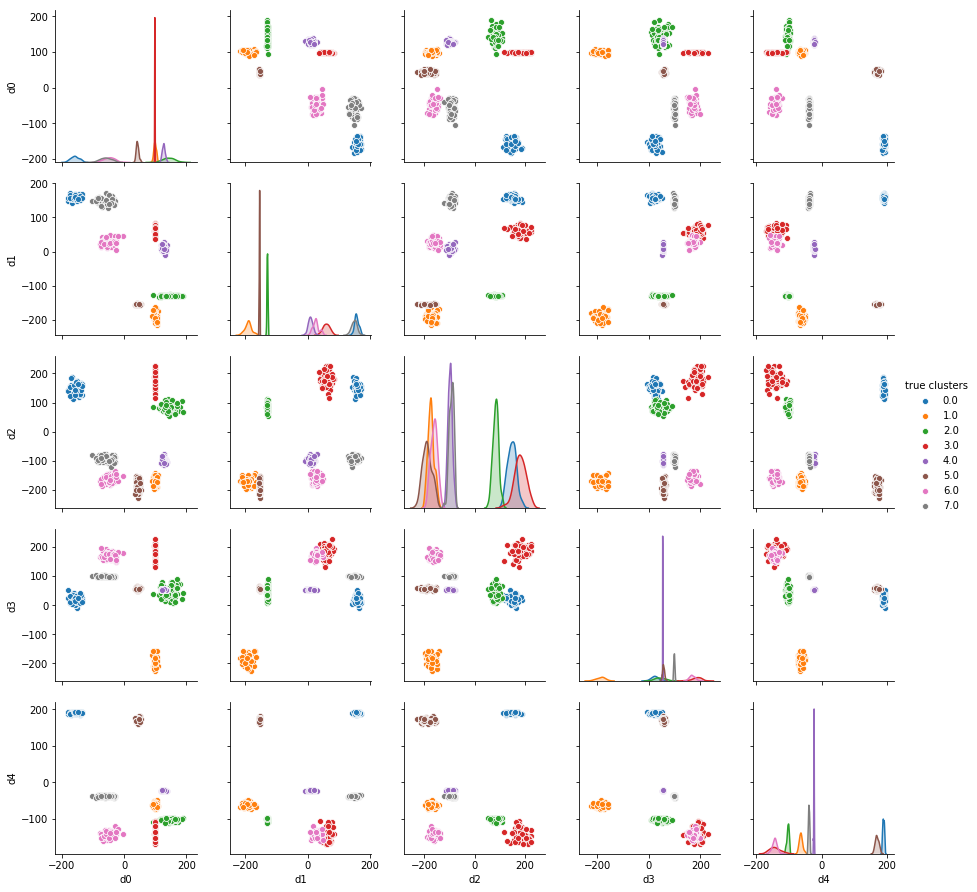

In [149]:
generate_dataset()

data = np.load('dummy_data.npy')
clusters_true = np.load('dummy_clusters.npy')

columns = ["d" + str(i) for i in range(data.shape[1])] + ['true clusters']
df = pd.DataFrame(np.hstack((data,np.reshape([clusters_true],(data.shape[0],1)))), columns=columns)
sns.pairplot(df, kind="scatter", hue='true clusters', vars=columns[:-1])

# f1 = data[:, 0]
# f2 = data[:, 1]
# X = np.array(list(zip(f1, f2)))
# plt.plot(f1, f2, 'ro')

## The agent

In [150]:
def distance(p, q, ord=2):
    return(np.linalg.norm(p-q, ord))

class ContrastAgent(object):
    def __init__(self, rigged_shuffle=False, verbose=False):
        self.clusters = np.array([])
        self.cluster_sizes = []
        self.data = np.array([[]])
        self.first_time = True
        self.nb_clusters = 0
        self.nb_seen = 0
        self.sensitiveness = 1.5 # if a point is alone with a radius of sensitiveness * stdist, create a new cluster
        self.stdist = 0
        self.verbose = verbose

    def clusterize_online(self):
        assert len(self.data), "empty data"
        if self.first_time:
            self.first_time = False
            self.new_cluster(0)
            self.one_more_seen()
        for i, p in enumerate(self.data[self.nb_seen:], start=self.nb_seen):
            self.find_cluster(i, p, i)
            self.one_more_seen()

    def feed_data(self, data):
        """Adds data to the agent's memory"""
        if self.first_time:
            self.data = np.copy(data)
            self.clusters = np.zeros(len(data))
            self.clusters.fill(-1)
        else:
            new_data = np.vstack((self.data, np.copy(data)))
            self.data = new_data
            new_clusters = np.zeros(len(data))
            new_clusters.fill(-1)
            new_clusters_all = np.hstack((self.clusters, new_clusters))
            self.clusters = new_clusters_all

    def find_cluster(self, i, p, until=None, recollection=False):
        distances = np.array([distance(p,q) for q in self.data[:until] if not np.all(p == q)])
        dist_min = np.min(distances)
        if not recollection:
            self.update_stdist(self.nb_seen, dist_min)
        closest = np.argmin(distances)
        if dist_min > self.sensitiveness * self.stdist:
#                 if self.verbose:
#                     print("new cluster")
            if self.clusters[i] == -1 or not self.cluster_sizes[int(self.clusters[i])] == 1:
                # if p not already seen or is not already alone
                self.new_cluster(i)
        else:
#                 if self.verbose:
#                     print("-> cluster of {}".format(closest))
            self.clusters[i] = self.clusters[closest]
            self.cluster_sizes[int(self.clusters[i])] += 1
            
    def new_cluster(self, p_index):
        self.clusters[p_index] = self.nb_clusters
        self.nb_clusters += 1
        self.cluster_sizes.append(1)

    def one_more_seen(self):
        self.nb_seen += 1

#     def print_clusters_old(self, only=-1):
#         self.colors = cm.rainbow(np.linspace(0, 1, self.nb_clusters))
#         for k in range(self.nb_clusters):
#             if only < 0 or k == only:
#                 points = np.array([self.data[i] for i in range(len(self.data)) if self.clusters[i] == k])
#                 plt.plot(points[:,0], points[:,1], 'o', color=self.colors[k])
                
    def print_clusters(self):
        columns = ["d" + str(i) for i in range(self.data.shape[1])] + ['cluster']
        df_1 = pd.DataFrame(np.hstack((self.data,np.reshape([self.clusters],(ca.data.shape[0],1)))),  columns=columns)
        sns.pairplot(df_1, kind="scatter", hue="cluster", vars=columns[:-1])
                
    def shuffle(self):
        np.random.shuffle(self.data)

    def update_clusters(self, until_update=None, until_dist=None):
        for i, p in enumerate(self.data[:until_update]):
            self.find_cluster(i, p, until_dist, recollection = True)
        
    def update_stdist(self, nb_seen, distance):
        self.stdist = (max(1,nb_seen) * self.stdist + distance) / (nb_seen + 1)

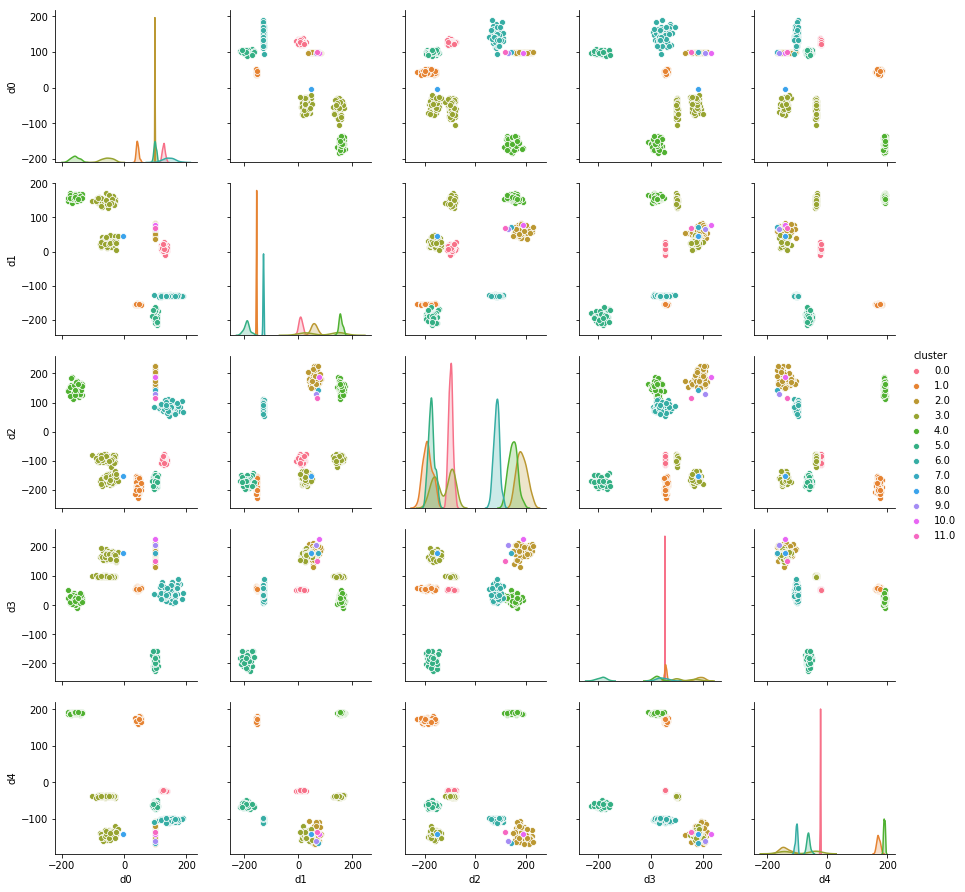

In [152]:
ca = ContrastAgent()
ca.feed_data(data)
# ca.shuffle()
ca.clusterize_online()
ca.print_clusters()

In [140]:
# ca.update_clusters()
# ca.print_clusters()